In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

# Normalization
x_train=x_train/255.

x_test=x_test/255.

#One-hot encoding
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))


In [38]:
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [224,224]) # if we want to resize 

x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [224,224]) # if we want to resize 

In [4]:
def Stem(input):
    x=layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(input)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x=layers.LayerNormalization()(x)
    x=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.LayerNormalization()(x)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)    
    return x


def Inception_Block(x,f1,f2,f3,f4,f5,f6):

    x1=layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
          
    x2=layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x2=layers.Conv2D(filters=f3,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x2)

    x3=layers.Conv2D(filters=f4 ,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x3=layers.Conv2D(filters=f5,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(x3)
       
    x4=layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    x4=layers.Conv2D(filters=f6,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x4)
    
    return tf.concat([x1,x2,x3,x4],axis=3)

def AUX1(input):
    ax=layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))(input)
    ax=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(ax)
    ax=layers.Flatten()(ax)
    ax=layers.Dense(units=1024,activation='relu')(ax)
    ax=layers.Dropout(0.7)(ax)
    ax=layers.Dense(units=10,activation='softmax',name='ax1')(ax)
    return ax

def AUX2(input):
    ax=layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))(input)
    ax=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(ax)
    ax=layers.Flatten()(ax)
    ax=layers.Dense(units=1024,activation='relu')(ax)
    ax=layers.Dropout(0.7)(ax)
    ax=layers.Dense(units=10,activation='softmax',name='ax2')(ax)
    return ax


def Classifier(input):
    fc=layers.AveragePooling2D(pool_size=(7,7),strides=(1,1))(input)
    fc=layers.Flatten()(fc)
    fc=layers.Dense(units=10,activation='softmax',name='output')(fc)    
    return fc

In [5]:
inputs=Input(shape=(224,224,1))
x=Stem(inputs)
x=Inception_Block(x,256,256,256,256,256,256)
x=Inception_Block(x,480,480,480,480,480,480)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception_Block(x,512,512,512,512,512,512)

ax1=AUX1(x)
x=Inception_Block(x,512,512,512,512,512,512)
x=Inception_Block(x,512,512,512,512,512,512)
x=Inception_Block(x,528,528,528,528,528,528)

ax2=AUX2(x)
x=Inception_Block(x,832,832,832,832,832,832)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception_Block(x,832,832,832,832,832,832)
x=Inception_Block(x,1024,1024,1024,1024,1024,1024)
output=Classifier(x)
   
model = tf.keras.models.Model(inputs,[output,ax1,ax2],name = 'GoogleNet')

In [6]:
model.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                          

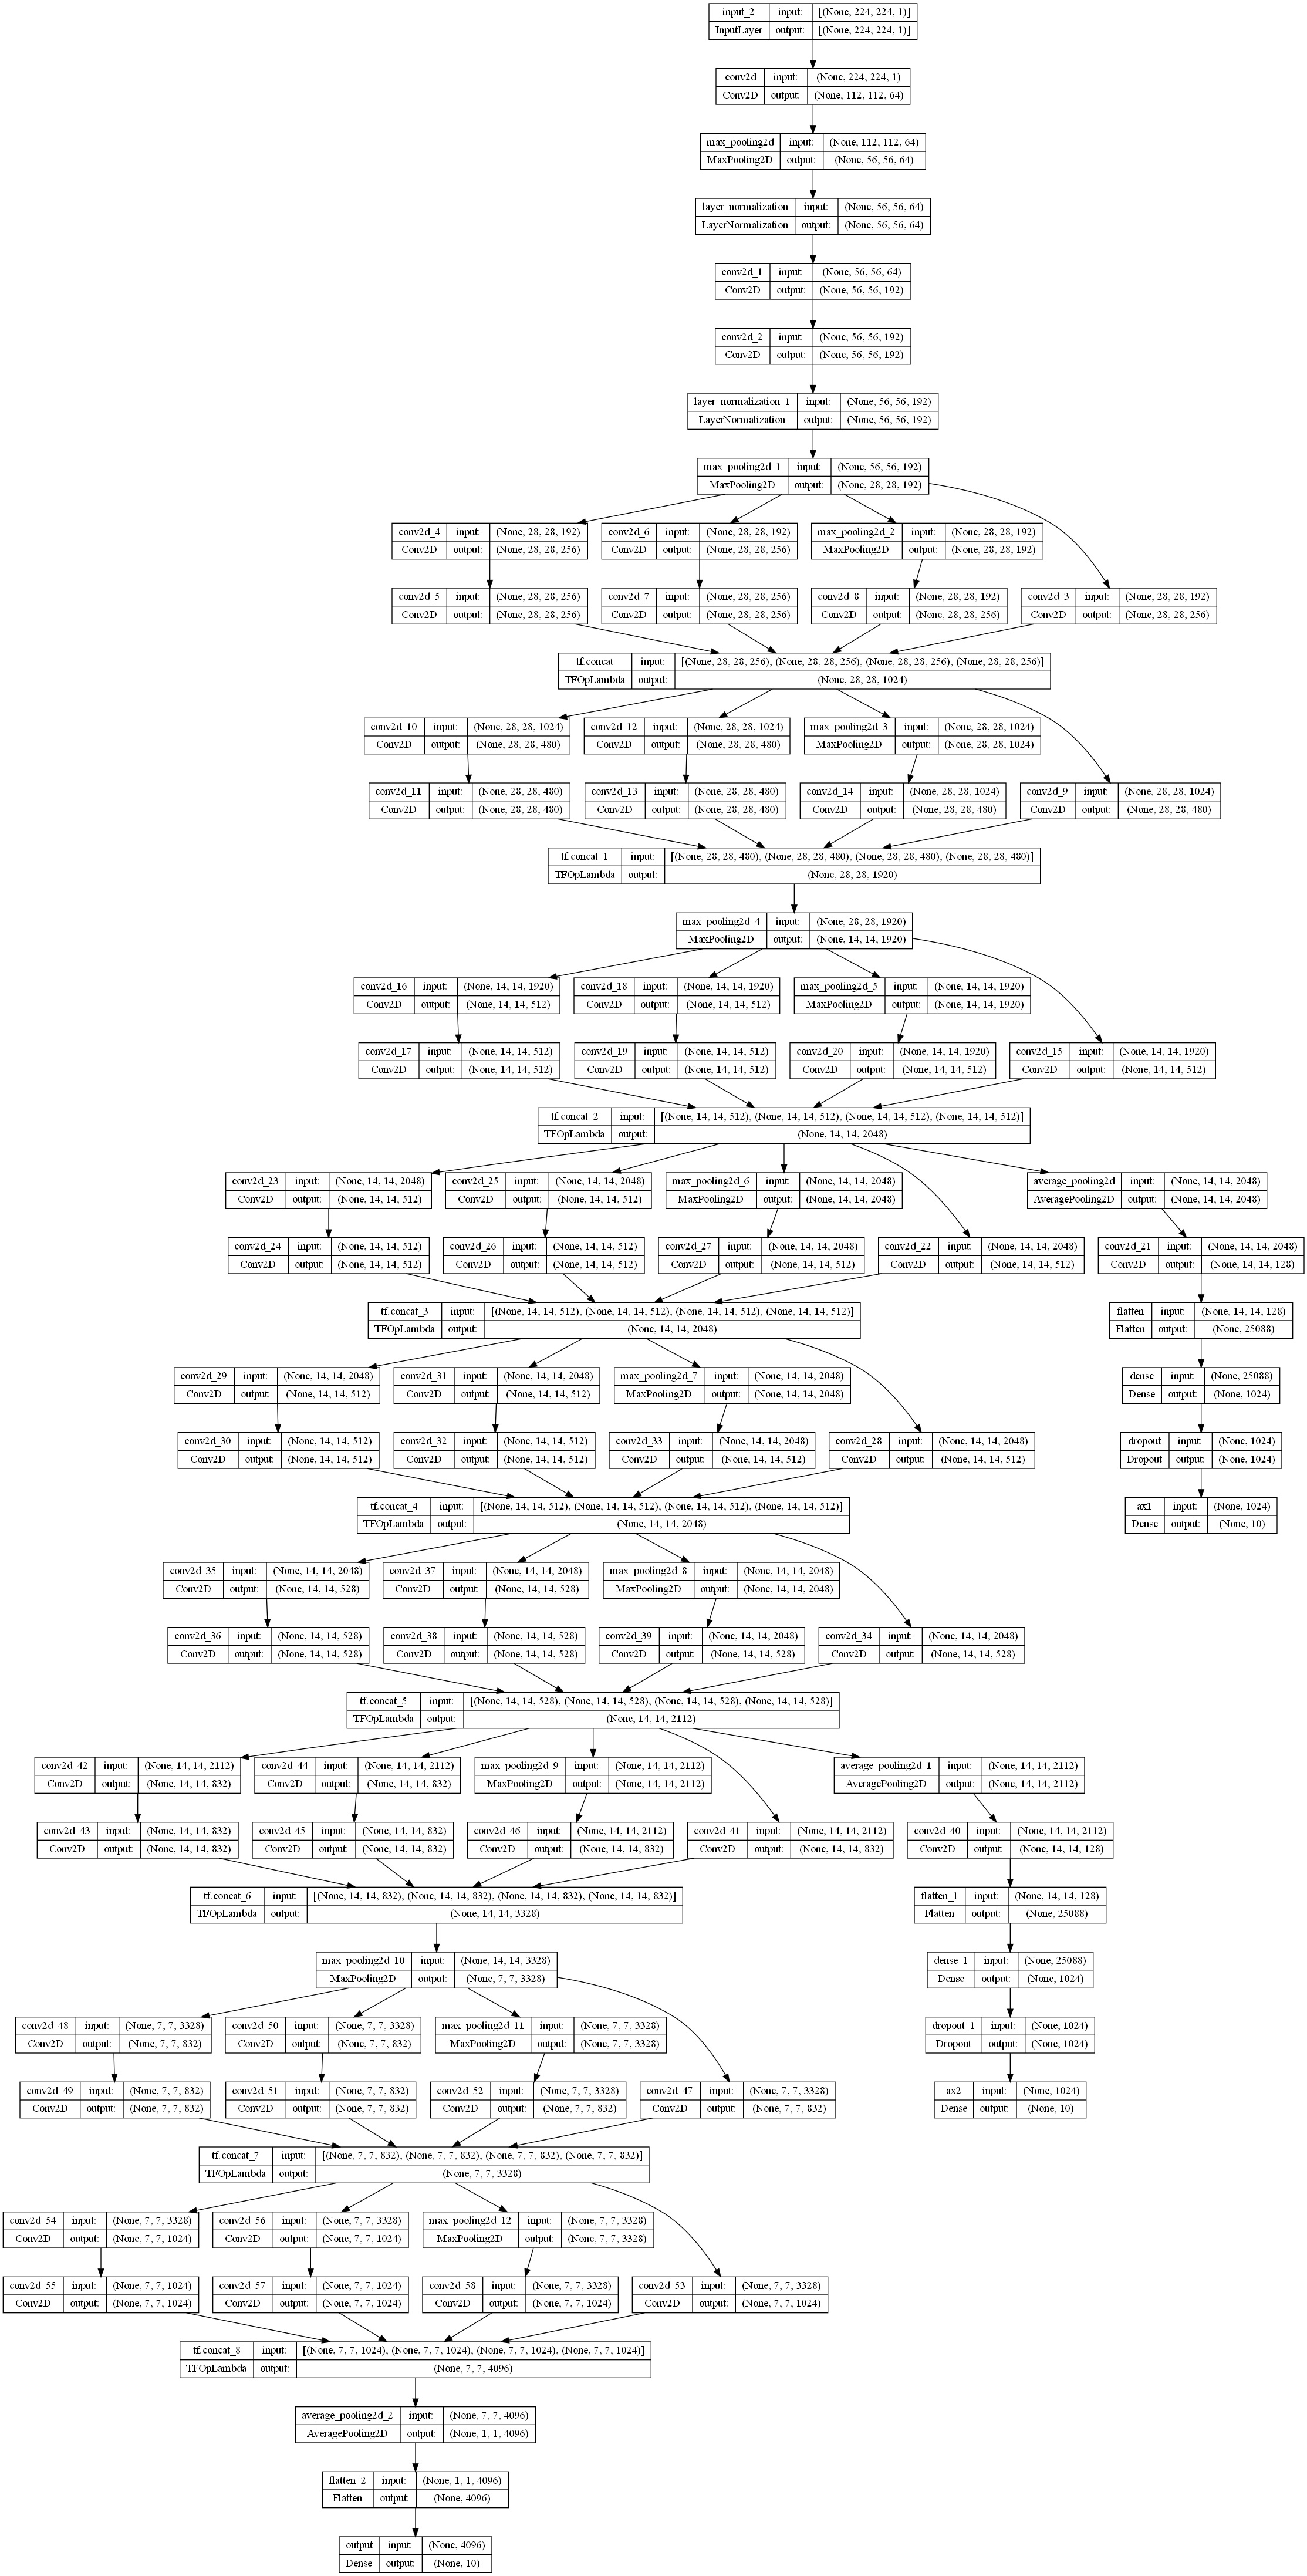

In [7]:
plot_model(model,to_file='GoogleNet.png',show_shapes=True)

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['acc'],loss_weights={'output':1, 'ax1':0., 'ax2':0})

In [70]:
history=model.fit(x_train,{'output':y_train,'ax1':y_train,'ax2':y_train},validation_data=(x_test,{'output':y_test,'ax1':y_test,'ax2':y_test}),epochs=10,batch_size=8,verbose=1)

Epoch 1/10
1184/7500 [===>..........................] - ETA: 16:00:09 - loss: 2.3257 - output_loss: 2.3257 - ax1_loss: 2.3293 - ax2_loss: 2.3027 - output_acc: 0.1053 - ax1_acc: 0.1023 - ax2_acc: 0.1019